# Training Tybalt models with two hidden layers

**Gregory Way 2017**

This script is an extension of [tybalt_vae.ipynb](tybalt_vae.ipynb). See that script for more details about the base model. Here, I train two alternative Tybalt models with different architectures. Both architectures have two hidden layers:

1. **Model A**: 5000 input -> 100 hidden -> 100 latent -> 100 hidden -> 5000 input
2. **Model B**: 5000 input -> 300 hidden -> 100 latent -> 300 hidden -> 5000 input

This notebook trains _both_ models. The optimal hyperparameters were selected through a grid search for each model independently.

The original tybalt model compressed 5000 input genes into 100 latent features in a single layer.

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

## Output

For both models, the script will output:

1. The learned latent feature matrix
2. Encoder and Decoder keras models with pretrained weights
3. An abstracted weight matrix

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
print(keras.__version__)
tf.__version__

2.0.5


'1.2.1'

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [4]:
np.random.seed(123)

## Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [5]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, var_layer, mean_layer, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + self.var_layer - K.square(self.mean_layer) - 
                                K.exp(self.var_layer), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [6]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

### Tybalt Model

The following class implements a Tybalt model with given input hyperparameters. Currently, only a two hidden layer model is supported.

In [7]:
class Tybalt():
    """
    Facilitates the training and output of tybalt model trained on TCGA RNAseq gene expression data
    """
    def __init__(self, original_dim, hidden_dim, latent_dim,
                 batch_size, epochs, learning_rate, kappa, beta):
        self.original_dim = original_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.beta = beta

    def build_encoder_layer(self):
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of size `latent_dim`
        # Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
        # and relu activation) are funneled separately
        # Each vector of length `latent_dim` are connected to the rnaseq input tensor
        hidden_dense_linear = Dense(self.hidden_dim, kernel_initializer='glorot_uniform')(self.rnaseq_input)
        hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
        hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

        z_mean_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
        self.z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

        z_log_var_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
        self.z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
        self.z = Lambda(sampling, output_shape=(self.latent_dim, ))([self.z_mean_encoded, self.z_log_var_encoded])
    
    def build_decoder_layer(self):
        # The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.hidden_dim, activation='relu', input_dim=self.latent_dim))
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid'))
        self.rnaseq_reconstruct = self.decoder_model(self.z)
        
    def compile_vae(self):
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = CustomVariationalLayer(self.z_log_var_encoded,
                                           self.z_mean_encoded)([self.rnaseq_input, self.rnaseq_reconstruct])
        self.vae = Model(self.rnaseq_input, vae_layer)
        self.vae.compile(optimizer=adam, loss=None, loss_weights=[self.beta])
        
    def get_summary(self):
        self.vae.summary()
    
    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.vae, to_file=output_file)
        SVG(model_to_dot(self.vae).create(prog='dot', format='svg'))
        
    def train_vae(self):
        self.hist = self.vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=self.epochs,
               batch_size=self.batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)),
               callbacks=[WarmUpCallback(self.beta, self.kappa)])
    
    def visualize_training(self, output_file):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('VAE Loss')
        fig = ax.get_figure()
        fig.savefig(output_file)
        
    def compress(self, df):
        # Model to compress input
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)
        
        # Encode rnaseq into the hidden/latent representation - and save output
        encoded_df = self.encoder.predict_on_batch(df)
        encoded_df = pd.DataFrame(encoded_df, columns=range(1, self.latent_dim + 1),
                                  index=rnaseq_df.index)
        return encoded_df
    
    def get_decoder_weights(self):
        # build a generator that can sample from the learned distribution
        decoder_input = Input(shape=(self.latent_dim, ))  # can generate from any sampled z vector
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)
        weights = []
        for layer in self.decoder.layers:
            weights.append(layer.get_weights())
        return(weights)
    
    def predict(self, df):
        return self.decoder.predict(np.array(df))
    
    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)

## Load Gene Expression Data

In [8]:
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [9]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

## Initialize variables and hyperparameters for each model

The hyperparameters provided below were determined through previous independent parameter searches

In [10]:
# Set common hyper parameters
original_dim = rnaseq_df.shape[1]
latent_dim = 100
beta = K.variable(0)
epsilon_std = 1.0

In [11]:
# Model A (100 hidden layer size)
model_a_latent_dim = 100
model_a_batch_size = 100
model_a_epochs = 100
model_a_learning_rate = 0.001
model_a_kappa = 1.0

In [12]:
# Model B (300 hidden layer size)
model_b_latent_dim = 300
model_b_batch_size = 50
model_b_epochs = 100
model_b_learning_rate = 0.0005
model_b_kappa = 0.01

## Create and process Tybalt Models

### Model A Training and Output

In [13]:
model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)

In [14]:
# Compile Model A
model_a.build_encoder_layer()
model_a.build_decoder_layer()
model_a.compile_vae()
model_a.get_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           500100      input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 100)           400         dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 100)           0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

/home/gway/anaconda3/envs/vae_pancancer/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [15]:
model_architecture_file = os.path.join('figures', 'twohidden_vae_architecture.png')
model_a.visualize_architecture(model_architecture_file)

In [16]:
%%time
model_a.train_vae()

Train on 9413 samples, validate on 1046 samples
Epoch 1/100
9413/9413 [==============================] - 1s - loss: 2957.9805 - val_loss: 2950.8238
Epoch 2/100
9413/9413 [==============================] - 1s - loss: 2797.2792 - val_loss: 2805.8403
Epoch 3/100
9413/9413 [==============================] - 1s - loss: 2763.9802 - val_loss: 2762.6554
Epoch 4/100
9413/9413 [==============================] - 1s - loss: 2746.9909 - val_loss: 2754.8216
Epoch 5/100
9413/9413 [==============================] - 1s - loss: 2735.1533 - val_loss: 2740.8744
Epoch 6/100
9413/9413 [==============================] - 1s - loss: 2725.5900 - val_loss: 2726.4276
Epoch 7/100
9413/9413 [==============================] - 1s - loss: 2718.8524 - val_loss: 2724.1144
Epoch 8/100
9413/9413 [==============================] - 1s - loss: 2713.2076 - val_loss: 2716.0569
Epoch 9/100
9413/9413 [==============================] - 1s - loss: 2708.3757 - val_loss: 2711.0041
Epoch 10/100
9413/9413 [============================

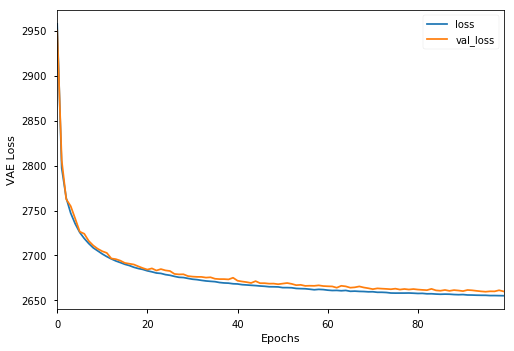

In [17]:
model_a_training_file = os.path.join('figures', 'twohidden_100hidden_training.pdf')
model_a.visualize_training(model_a_training_file)

In [18]:
model_a_compression = model_a.compress(rnaseq_df)
model_a_file = os.path.join('data', 'encoded_rnaseq_twohidden_100model.tsv.gz')
model_a_compression.to_csv(model_a_file, sep='\t', compression='gzip')
model_a_compression.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
TCGA-02-0047-01,1.804567,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.082371,0.000000,0.0,...,5.628737,0.882983,0.0,0.000000,1.976136,1.912838,3.621609,0.000000,1.947124,1.840908
TCGA-02-0055-01,0.635178,0.0,1.591518,0.029515,1.855888,0.0,0.0,4.964176,1.741375,0.0,...,1.160538,0.000000,0.0,1.639663,0.000000,0.000000,4.046312,0.304179,6.382465,0.919127


In [19]:
model_a_weights = model_a.get_decoder_weights()

In [20]:
encoder_model_a_file = os.path.join('models', 'encoder_twohidden100_vae.hdf5')
decoder_model_a_file = os.path.join('models', 'decoder_twohidden100_vae.hdf5')
model_a.save_models(encoder_model_a_file, decoder_model_a_file)

### Model B Training and Output

In [21]:
model_b = Tybalt(original_dim=original_dim,
                 hidden_dim=model_b_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_b_batch_size,
                 epochs=model_b_epochs,
                 learning_rate=model_b_learning_rate,
                 kappa=model_b_kappa,
                 beta=beta)

In [22]:
# Compile Model B
model_b.build_encoder_layer()
model_b.build_decoder_layer()
model_b.compile_vae()
model_b.get_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 300)           1500300     input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 300)           1200        dense_6[0][0]                    
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 300)           0           batch_normalization_4[0][0]      
___________________________________________________________________________________________

/home/gway/anaconda3/envs/vae_pancancer/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


In [23]:
%%time
model_b.train_vae()

Train on 9413 samples, validate on 1046 samples
Epoch 1/100
9413/9413 [==============================] - 2s - loss: 2976.0963 - val_loss: 2909.1827
Epoch 2/100
9413/9413 [==============================] - 1s - loss: 2859.1518 - val_loss: 2852.9602
Epoch 3/100
9413/9413 [==============================] - 1s - loss: 2835.7822 - val_loss: 2827.6078
Epoch 4/100
9413/9413 [==============================] - 1s - loss: 2822.8338 - val_loss: 2822.6562
Epoch 5/100
9413/9413 [==============================] - 1s - loss: 2814.4313 - val_loss: 2811.0809
Epoch 6/100
9413/9413 [==============================] - 1s - loss: 2807.8876 - val_loss: 2807.1923
Epoch 7/100
9413/9413 [==============================] - 1s - loss: 2803.3193 - val_loss: 2801.9632
Epoch 8/100
9413/9413 [==============================] - 1s - loss: 2800.3531 - val_loss: 2801.8731
Epoch 9/100
9413/9413 [==============================] - 1s - loss: 2796.8033 - val_loss: 2795.0505
Epoch 10/100
9413/9413 [============================

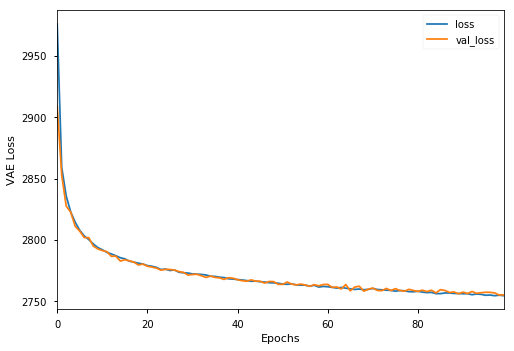

In [24]:
model_b_training_file = os.path.join('figures', 'twohidden_300hidden_training.pdf')
model_b.visualize_training(model_b_training_file)

In [25]:
model_b_compression = model_b.compress(rnaseq_df)
model_b_file = os.path.join('data', 'encoded_rnaseq_twohidden_300model.tsv.gz')
model_b_compression.to_csv(model_b_file, sep='\t', compression='gzip')
model_b_compression.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
TCGA-02-0047-01,0.000000,0.0,1.250155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.95250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-02-0055-01,0.556497,0.0,0.056864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.13956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
model_b_weights = model_b.get_decoder_weights()

In [27]:
encoder_model_b_file = os.path.join('models', 'encoder_twohidden300_vae.hdf5')
decoder_model_b_file = os.path.join('models', 'decoder_twohidden300_vae.hdf5')
model_b.save_models(encoder_model_b_file, decoder_model_b_file)

## Extract the abstract connections between samples and genes

In a two layer model, there are two sets of learned weights between samples and latent features and from latent features to reconstructed samples. The first set connects the genes to the hidden layer and the second set connects the hidden layer to the latent feature activation. The two layers can be connected by matrix multiplication, which provides a direct connection from gene to latent feature. It is likely that the two layers learn different biological features, but the immediate connection is easiest to currently analyze and intuit.

In [28]:
def extract_weights(weights, weight_file):
    # Multiply hidden layers together to obtain a single representation of gene weights
    intermediate_weight_df = pd.DataFrame(weights[1][0])
    hidden_weight_df = pd.DataFrame(weights[1][2])
    abstracted_weight_df = intermediate_weight_df.dot(hidden_weight_df)

    abstracted_weight_df.index = range(1, 101)
    abstracted_weight_df.columns = rnaseq_df.columns
    abstracted_weight_df.to_csv(weight_file, sep='\t')

In [29]:
# Model A
model_a_weight_file = os.path.join('data', 'tybalt_gene_weights_twohidden100.tsv')
extract_weights(model_a_weights, model_a_weight_file)

In [30]:
# Model B
model_b_weight_file = os.path.join('data', 'tybalt_gene_weights_twohidden300.tsv')
extract_weights(model_b_weights, model_b_weight_file)